# Models and Evaluation

In [185]:
import pandas as pd
import numpy as np
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from IPython.display import display

data = pd.read_csv('data_processed/complete/data_selected.csv')

display(data.head())

loan_id  loan_payments  has_disponent  mean_balance  min_balance  \
0     5314           8033          False  12250.000000       1100.0   
1     5316           4610          False  52083.859459        700.0   
2     6863           2118          False  30060.954167        800.0   
3     5325           2939          False  41297.480000       1000.0   
4     7240           4579          False  57188.211111        600.0   

   monthly_diff  crime rate growth  has_card  status  
0          6700          -0.001909     False      -1  
1         14733          -0.002094     False       1  
2         -6859           0.000539     False       1  
3        -11054          -0.001739     False       1  
4        -30531          -0.001179     False       1

In [186]:
def get_features(df):
    return df.drop(['status', 'loan_id'], axis=1)
def get_target(df):
    return df['status']
results = {}

### Split data

In [187]:
from sklearn.model_selection import train_test_split

_X_train, _X_test, _y_train, _y_test = train_test_split(get_features(data), get_target(data), test_size=0.25, random_state=11, stratify=get_target(data))

In [188]:
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold


stratified_kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=11)

In [189]:
from matplotlib import gridspec, pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from sklearn.model_selection import GridSearchCV
import seaborn as sb
from datetime import datetime
import json


param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'classifier__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              }
def grid_search(name, pipeline, param_grid):
    grid_search = GridSearchCV(estimator=pipeline,
                            param_grid=param_grid,
                            scoring='roc_auc',
                            cv=stratified_kfold,
                            n_jobs=-1)

    grid_search.fit(_X_train, _y_train)
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_

    test_score = grid_search.score(_X_test, _y_test)
    print(f'Cross-validation score: {best_score}\nTest score: {test_score}')

    gs = gridspec.GridSpec(2, 2)
    fig = plt.figure(figsize=(20, 16))
    ax = plt.subplot(gs[0, 0])
    sb.histplot(data=grid_search.cv_results_, x='mean_test_score', kde=True, ax=ax)
    ax = plt.subplot(gs[0, 1])
    sb.boxplot(data=grid_search.cv_results_, x='mean_test_score', ax=ax)
    ax = plt.subplot(gs[1, 0])
    RocCurveDisplay.from_estimator(grid_search, _X_test, _y_test, ax=ax)
    ax = plt.subplot(gs[1, 1])
    PrecisionRecallDisplay.from_estimator(best_estimator, _X_test, _y_test, ax=ax)
    
    with open('grid_search_results/'+name+'_'+str(datetime.timestamp(datetime.now()))+'.json', 'w') as f:
        json.dump({'best_params': str(best_params), 'best_score': best_score}, f)

In [190]:
def make_pipeline(classifier, smote = False, scaler = None):
    steps = []
    if smote: steps.append(['smote', SMOTE(random_state=11)])
    if scaler: steps.append(['scaler', scaler])
    steps.append(['classifier', classifier])
    return imbpipeline(steps = steps)

In [191]:
SEARCH = True
smote = True
scaler = None

Cross-validation score: 0.8138058324104837
Test score: 0.6818181818181819


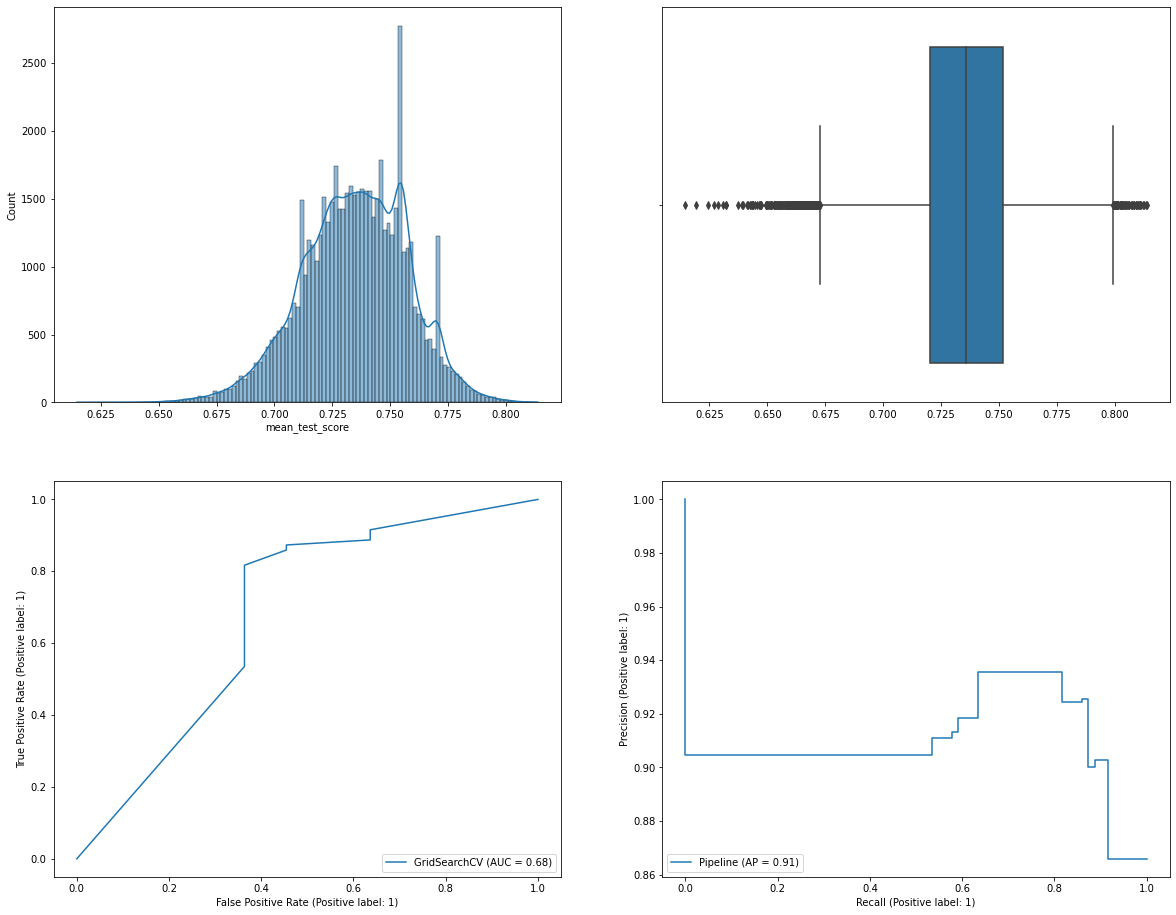

In [192]:
from sklearn.tree import DecisionTreeClassifier
if SEARCH:
    grid_search('dtc',
        make_pipeline(
            DecisionTreeClassifier(),
            smote=smote,
            scaler=scaler
        ),
        param_grid={
            'classifier__criterion': ['gini', 'entropy', 'log_loss'],
            'classifier__max_depth': [None, 5, 7, 11, 13, 17, 21, 35],
            'classifier__min_samples_split': [2, 4, 6, 8, 10, 20],
            'classifier__min_samples_leaf': [1, 2, 3, 4, 5, 7, 9, 10],
            'classifier__max_features': [None,'sqrt', 'log2'],
            'classifier__max_leaf_nodes': [None, 5, 7, 11, 13, 17, 21, 35],
        }
    )

Cross-validation score: 0.724328956388757
Test score: 0.7176696542893725


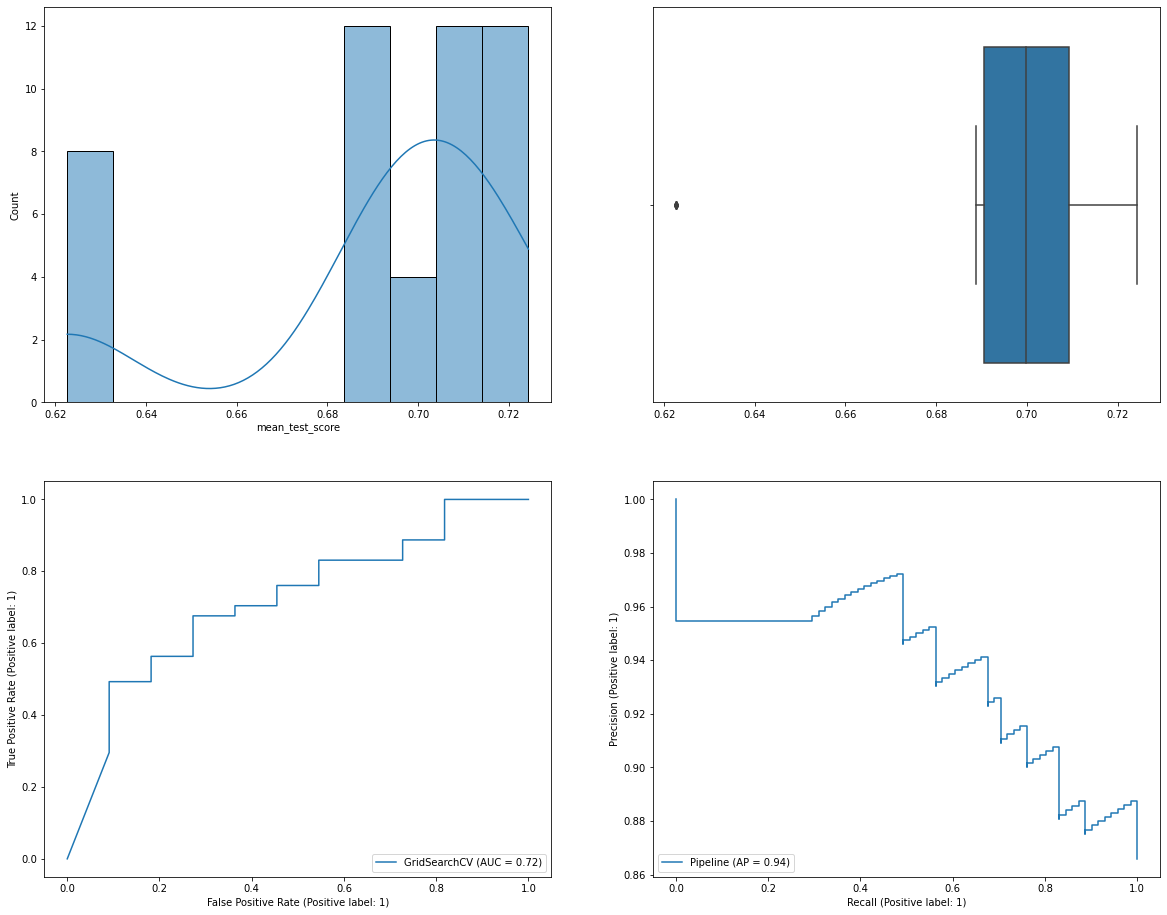

In [193]:
from sklearn.neighbors import KNeighborsClassifier
if SEARCH:
    grid_search('knn',
        make_pipeline(
            KNeighborsClassifier(),
            smote=smote,
            scaler=scaler
        ),
        param_grid={
            'classifier__n_neighbors': [1, 3, 5, 7, 9, 11],
            'classifier__weights': ['uniform', 'distance'],
            'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
        }
    )

In [194]:
from sklearn.neural_network import MLPClassifier
if SEARCH and False:
    grid_search('mlp',
        make_pipeline(
            MLPClassifier(),
            smote=smote,
            scaler=scaler
        ),
        param_grid={
            
        }
    )

In [195]:
from sklearn.naive_bayes import GaussianNB
if SEARCH and False:
    grid_search('gnb',
        make_pipeline(
            GaussianNB(),
            smote=smote,
            scaler=scaler
        ),
        param_grid={
            
        }
    )

/home/rikenunes8/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/rikenunes8/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/rikenunes8/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/rikenunes8/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/rikenunes8/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:301: C

Cross-validation score: 0.8441649528028264
Test score: 0.8169014084507042


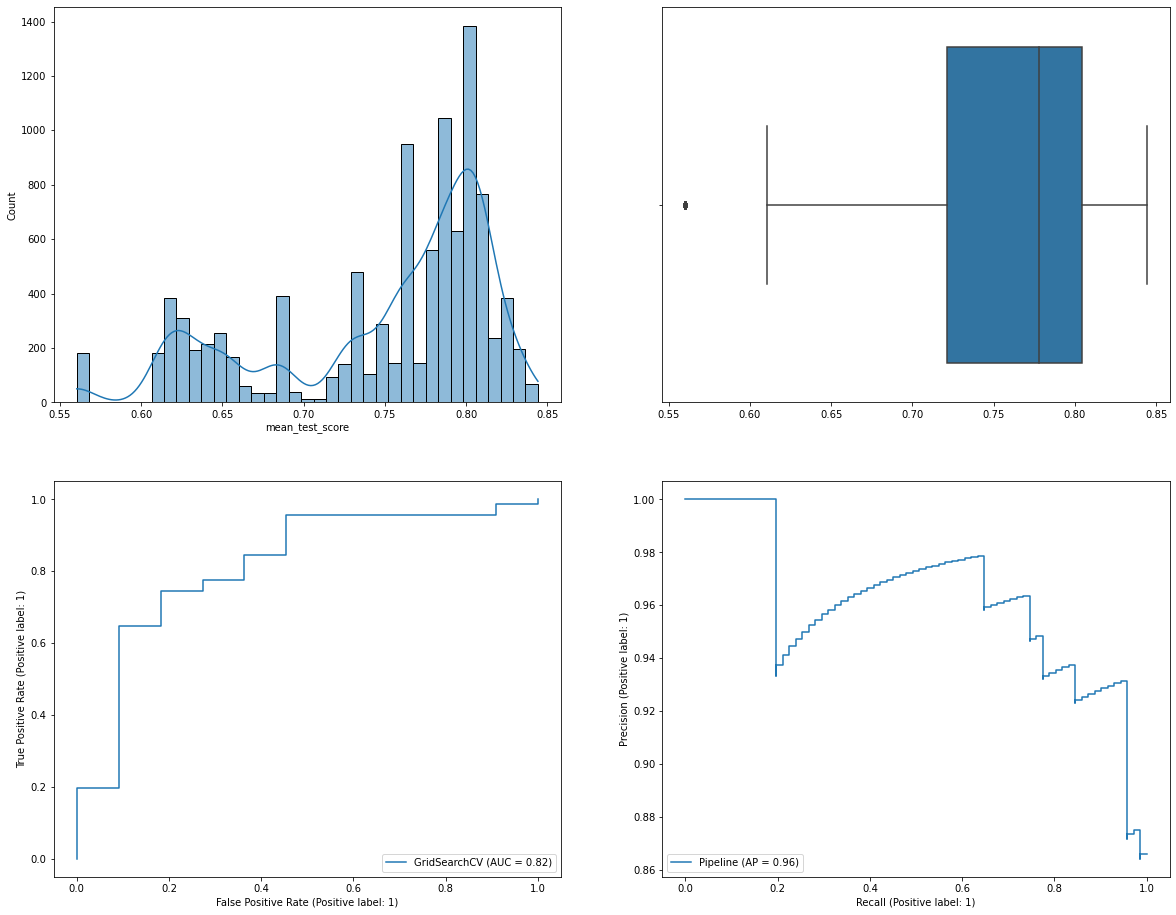

In [196]:
from sklearn.svm import SVC
if SEARCH:
    grid_search('svc',
        make_pipeline(
            SVC(probability=True, max_iter=10000),
            smote=smote,
            scaler=StandardScaler()
        ),
        param_grid={
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'classifier__degree': [1, 2, 3, 5, 7],
            'classifier__gamma': ['scale', 'auto'],
            'classifier__coef0': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
            'classifier__shrinking': [True, False],
            'classifier__tol': [0.01, 0.001, 0.0001],
        }
    )

/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Cross-validation score: 0.8178452776459421
Test score: 0.8348271446862996


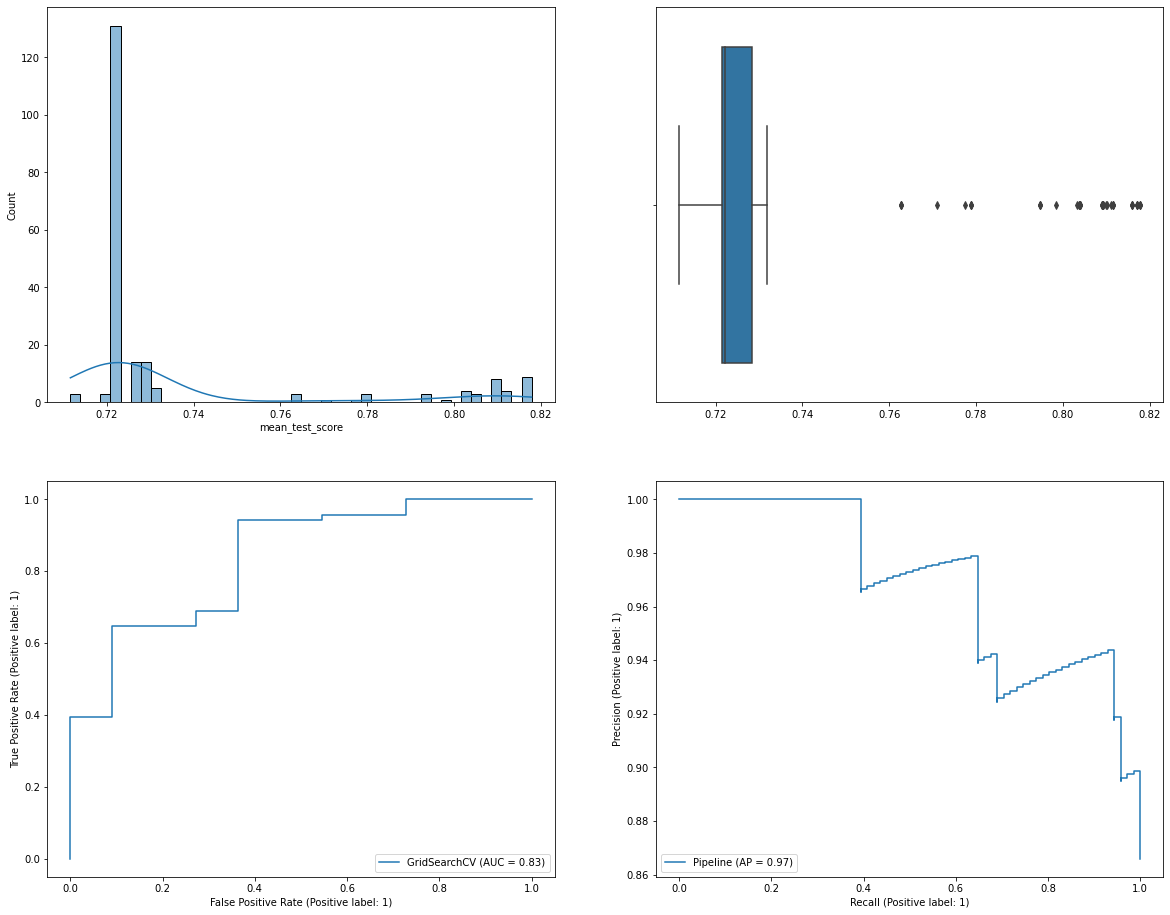

In [197]:
from sklearn.linear_model import LogisticRegression
if SEARCH:
    grid_search('lr',
        make_pipeline(
            LogisticRegression(max_iter=10000),
            smote=smote,
            scaler=scaler
        ),
        param_grid={
            'classifier__tol': [0.001, 0.0001, 0.00001],
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'classifier__fit_intercept': [True, False],
            'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        }
    )



Cross-validation score: 0.8433528450139746
Test score: 0.765685019206146


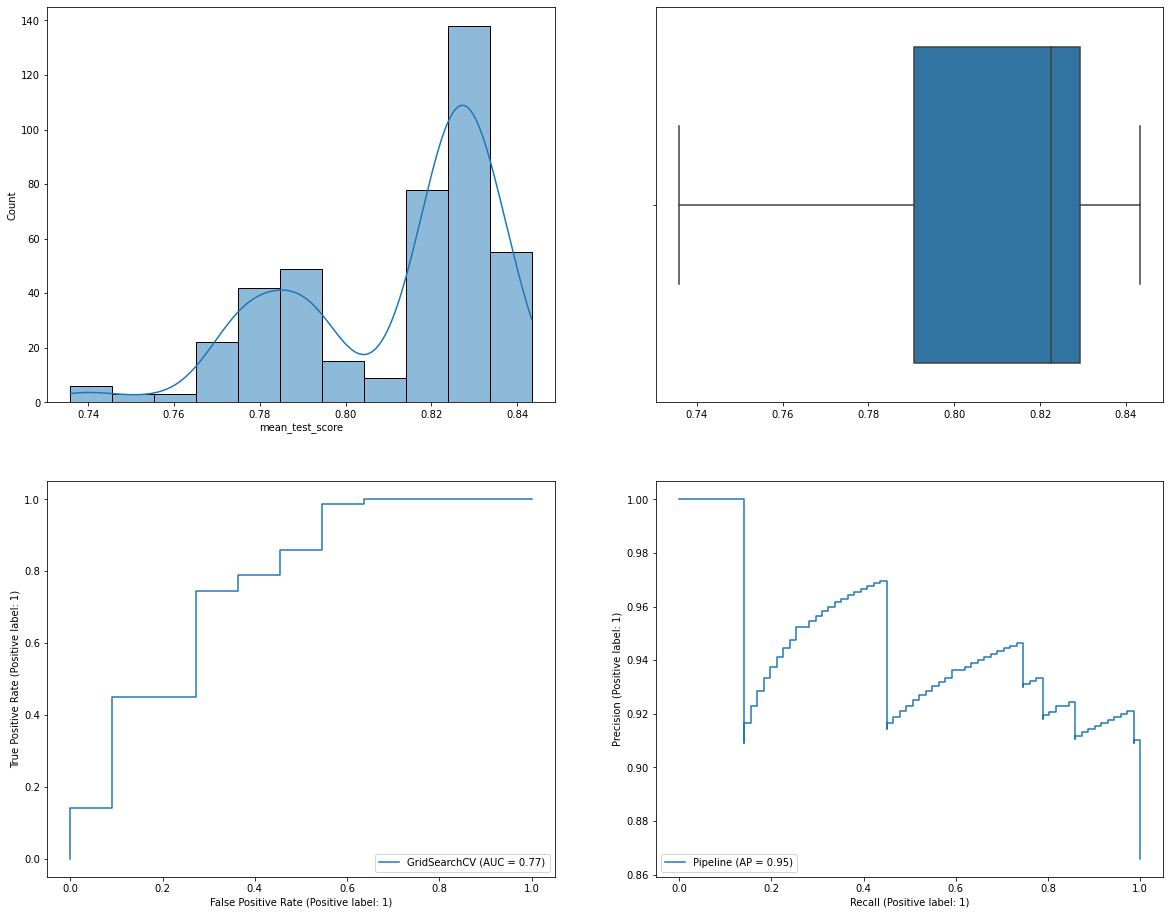

In [198]:
from sklearn.ensemble import RandomForestClassifier
if SEARCH:
    grid_search('rf',
        make_pipeline(
            RandomForestClassifier(),
            smote=smote,
            scaler=scaler
        ),
        param_grid={
            'classifier__n_estimators': [40, 75, 100, 150, 200],
            'classifier__criterion': ["gini", "entropy"],
            'classifier__max_depth': np.arange(2, 30, 2),
            'classifier__max_features': ["sqrt", "log2", None],
        }
    )